### IBGE - visualização
Arquivo utilizado para a visualização dos dados do IBGE

In [1]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns
import pandas as pd
import re 

import var as var

In [11]:
divisor = 0
notValidCols = ['2009', '2010', '2020']
showLogs = False

def setIDH(dataFrame):

    dataFrameINEP = pd.read_csv(f'./result/INEP.csv')
    idhm = pd.read_csv(f'./data/ibge/idh/data.csv', sep=';')
    idhm['Município'] = idhm['Município'].apply(lambda x: re.sub(r'\s\(\w+\)', '', x))
    validIdhm = idhm[idhm['Município'].isin(dataFrameINEP['NO_MUNICIPIO'].unique())]

    for nomeMunicipio in dataFrame['NO_MUNICIPIO'].unique().tolist():
        idhmMunicipio = validIdhm[validIdhm['Município'] == nomeMunicipio]

        if len(idhmMunicipio) == 0:
            continue

        dataFrame.loc[dataFrame['NO_MUNICIPIO'] == nomeMunicipio, 'IDHM'] = idhmMunicipio['IDHM 2010'].values[0]
    
    dataFrame['IDHM'].fillna(0, inplace=True)

    for nome in dataFrame.loc[dataFrame['IDHM'] == 0,'NO_MUNICIPIO']:
        if nome == 'Pontes e Lacerda':
            nomeBusca = 'Pontes E Lacerda'
        else:
            nomeBusca = nome
        dataFrame.loc[dataFrame['NO_MUNICIPIO'] == nome, 'IDHM'] = idhm.loc[idhm['Município'] == nomeBusca, 'IDHM 2010'].values[0]

    return dataFrame

def groupByYear(dataFrame):
    dataFrameBackup = dataFrame
    dataFrame = dataFrame.groupby(['NO_MUNICIPIO', 'CO_MUNICIPIO']).sum().reset_index()

    for col in var.IBGE_COLUMNS:
        for codMunicipio in dataFrame['CO_MUNICIPIO'].unique().tolist():
            
            for cdIes in dataFrameBackup.loc[dataFrameBackup['CO_MUNICIPIO'] == codMunicipio, 'CO_IES'].unique().tolist():
                dataFrame.loc[dataFrame['CO_MUNICIPIO'] == codMunicipio, col] = dataFrameBackup.loc[(dataFrameBackup['CO_MUNICIPIO'] == codMunicipio) & (dataFrameBackup['CO_IES'] == cdIes), col].sum()
                break

    return dataFrame

def groupByNameAndYear(dataFrame):
    return dataFrame[['ANO', 'NO_MUNICIPIO', 'CO_MUNICIPIO'] + var.IBGE_COLUMNS + var.INEP_COLUMNS].groupby(['ANO', 'NO_MUNICIPIO', 'CO_MUNICIPIO'] + var.IBGE_COLUMNS).sum().reset_index()

def formatar_rotulos(valor, e):
    return '{:.0f}'.format(valor / divisor)

def substituir_virgula(valor):
    return valor.replace(',', '.')

def makeIDH(dataFrame):

    idhm = pd.read_csv(f'./data/ibge/idh/data.csv', sep=';')
    idhm['Município'] = idhm['Município'].apply(lambda x: re.sub(r'\s\(\w+\)', '', x))
    
    idhm['IDHM 2010'] = idhm['IDHM 2010'].astype(str)
    idhm['IDHM 2010'] = idhm['IDHM 2010'].apply(lambda x: substituir_virgula(x))
    idhm['IDHM 2010'] = idhm['IDHM 2010'].astype(float)

    fig = plt.figure(figsize=(8, 5))
    
    sns.boxplot(data=[idhm['IDHM 2010'].values.tolist()] + [dataFrame['IDHM'].values.tolist()], palette=['red', 'blue'])
    plt.xticks(range(2), ['Conjunto\ntotal', 'Conjunto de\ncomputação'])
    
    plt.ylabel('IDH')
    plt.savefig('./result/IBGE_IDH.png')

def generateVisualization(dataFrame, pib=False, pop=False, idh=False):
    global divisor
    
    if pop:
        divisor = 1000000
    elif pib:
        divisor = 1000000000
    
    if (pib and pop and idh) or (not pib and not pop and not idh):
        print('Erro!')
        return
    
    dicTotal = {}
    dicComputacao = {}

    if pop:
        label = 'População'
        column = 'IBGE_MUNICIPIO_POP'
        chartLabel = 'População (Milhões)'
        dataTotal = pd.read_csv(f'./data/ibge/populacao/data.csv', sep=';')
    elif pib:
        label = 'PIB'
        column = 'IBGE_MUNICIPIO_PIB'
        chartLabel = 'PIB (Bilhões)'
        dataTotal = pd.read_csv(f'./data/ibge/pib/data.csv', sep=';')
    elif idh:
        makeIDH(dataFrame)
        return
    
    if showLogs:
        display(dataTotal)
    
    tot = 0
    if showLogs:
        print(f'>> {label} total:')

    for col in dataTotal.columns:
        
        if col != 'Cód.' and col != 'Município' and col not in notValidCols:
            dataTotal.loc[dataTotal[col] == '...', col] = 0

            if pop:
                dataTotal[col] = dataTotal[col].astype(int)
            elif pib:
                dataTotal[col] = dataTotal[col].astype(str)
                dataTotal[col] = dataTotal[col].apply(lambda x: substituir_virgula(x))
                dataTotal[col] = dataTotal[col].astype(float)

            dicTotal[col] = dataTotal[col].sum()
            tot += dataTotal[col].sum()

            if showLogs:
                print('{}: {}'.format(col, dataTotal[col].sum()))

    if showLogs:
        print('>> Total: {}\n\n'.format(tot))

    tot2 = 0

    if showLogs:
        print('>> População computação:')
    for ano in dataFrame['ANO'].unique():
        if str(ano) in notValidCols:
            continue

        dataAno = dataFrame[dataFrame['ANO'] == ano]
        dicComputacao[str(ano)] = dataAno[column].sum()
        tot2 += dataAno[column].sum()
        if showLogs:
            print('{}: {}'.format(ano, dataAno[column].sum()))

    if showLogs:
        print('>> Total: {}\n\n'.format(tot2))

    pct = []
    for ano in dicTotal.keys():
        conta = round((dicComputacao[ano]*100) / dicTotal[ano], 1)
        pct.append(str(conta) + ' %')

        if showLogs:
            print('{}:\n>>> porcentagem de computação: {}%'.format(ano, conta))

    if showLogs:
        print('\n>>> porcentagem TOTAL de computação: {}%\n\n'.format(round((tot2*100) / tot, 2)))

    # Definindo as cores para cada par de valores
    cores = ['red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red']
    cores2 = ['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']

    fig = plt.figure(figsize=(8, 5))

    # Configurando o gráfico de barras
    plt.bar(dicComputacao.keys(), dicTotal.values(), color=cores, label='Total')
    plt.bar(dicComputacao.keys(), dicComputacao.values(), color=cores2, label='Computação')

    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(formatar_rotulos))

    # Adicionando legendas e rótulos
    plt.xlabel('Ano', size=12)
    plt.ylabel(chartLabel, size=12)

    annotateValues = [
        [-0.37, '2011'],
        [0.63, '2012'],
        [1.63, '2013'],
        [2.63, '2014'],
        [3.63, '2015'],
        [4.63, '2016'],
        [5.63, '2017'],
        [6.63, '2018'],
        [7.63, '2019'],
    ]

    for i, value in enumerate(annotateValues):
        plt.annotate(pct[i], (value[0], dicComputacao[value[1]]/2), color='white', size=10)

    plt.savefig(f'./result/IBGE_{label.upper()}.png')
    plt.show()
    

In [3]:
dataFrameIBGE = pd.read_csv(f'./result/IBGE.csv')

# agrupamento pelo ano
dataFrameYear = groupByYear(dataFrameIBGE)
dataFrameYearIDH = setIDH(dataFrameYear)

# agrupamento pelo municipio e ano
dataFrameYearName = groupByNameAndYear(dataFrameIBGE)

C:\Users\aliss\AppData\Local\Temp\ipykernel_13060\2312843896.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dataFrame = dataFrame.groupby(['NO_MUNICIPIO', 'CO_MUNICIPIO']).sum().reset_index()


#### Comparação entre os anos, da população total do Brasil (representados pela cor vermelha), e dos municípios que ofertam cursos de computação (representados pela cor azul).

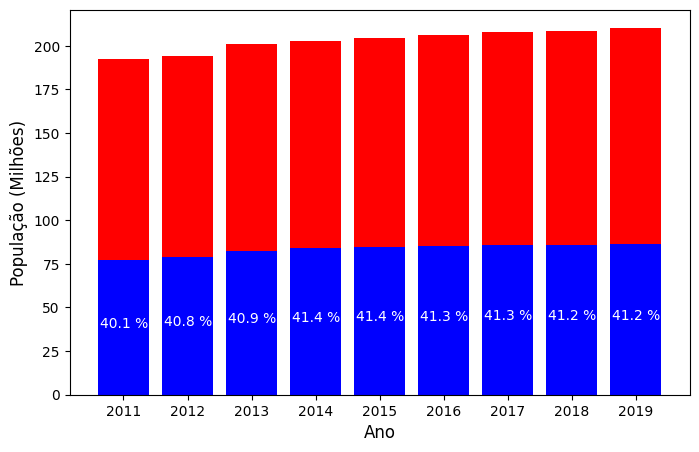

In [12]:
generateVisualization(dataFrameYearName, pop=True)

#### Comparação entre os anos, do PIB Brasileiro (representados pela cor vermelha), e dos municípios que ofertam cursos de computação (representados pela cor azul).

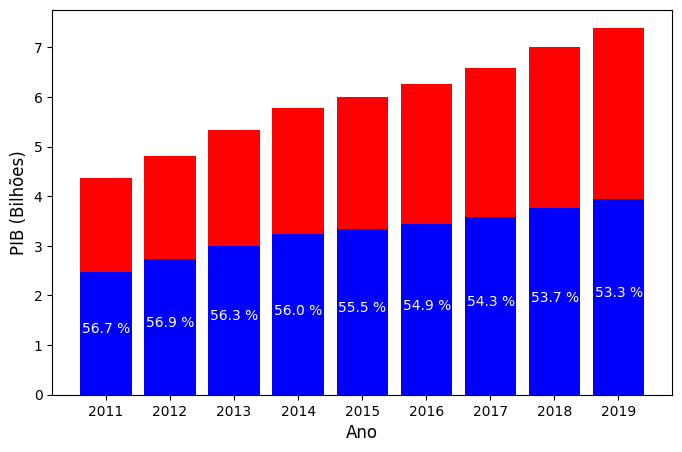

In [13]:
generateVisualization(dataFrameYearName, pib=True)

#### Comparação do IDH dos municípios brasileiros (representados pela cor vermelha), e dos municípios que ofertam cursos de computação (representados pela cor azul).

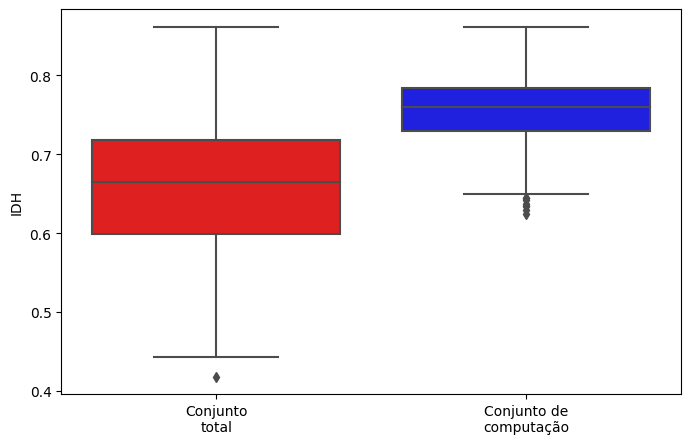

In [6]:
generateVisualization(dataFrameYearIDH, idh=True)